In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9). 

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [ ]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
# image_type = 'indoor'
image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [ ]:
# img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
# img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
# image_pair = [img0_pth, img1_pth]
# image_pair = [img1_pth, img0_pth]

In [ ]:
image_type = 'outdoor'

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 565 kB 55.5 MB/s 
Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 173 (delta 26), reused 140 (delta 21), pack-reused 0
Receiving objects: 100% (173/173), 26.29 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/weights
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.co

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.

def LoFTR(img0_raw, img1_raw):

  # img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
  # img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
  
  img0_raw = cv2.resize(img0_raw, (640, 480))
  img1_raw = cv2.resize(img1_raw, (640, 480))

  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()




  df = {'confidence': list(mconf), 'mkpts0': list(mkpts0), 'mkpts1': list(mkpts1)}
  df = pd.DataFrame(df)
  df.sort_values(by=['confidence'], ascending=False)

  mkpts0, mkpts1, mconf = np.array(list(df['mkpts0'])[:1000]), np.array(list(df['mkpts1'])[:1000]), np.array(list(df['confidence'])[:1000]) 
  print(type(mconf), type(mkpts0), type(mkpts1))


  color = cm.jet(mconf, alpha=0.7)
  text = [
      'LoFTR',
      'Matches: {}'.format(len(mkpts0)),
  ]
  fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

  # A high-res PDF will also be downloaded automatically.
  make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
  # files.download("LoFTR-colab-demo.pdf")

  return mkpts0, mkpts1

In [ ]:
# # Draw 
# color = cm.jet(mconf, alpha=0.7)
# text = [
#     'LoFTR',
#     'Matches: {}'.format(len(mkpts0)),
# ]
# fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# # A high-res PDF will also be downloaded automatically.
# make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
# # files.download("LoFTR-colab-demo.pdf")

In [ ]:
def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  mkpts0, mkpts1 = LoFTR(im1Gray, im2Gray)

  # print(mkpts0)
  # print(len(mkpts1))

  h, mask = cv2.findHomography(mkpts1, mkpts0, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

  return im1Reg, h

In [ ]:
# img3 = cv2.imread('/content/drive/MyDrive/DREAMS-LAB/Multispectral/Week2/Week2_Apr28_11AM/IMG_0017_3.tif')
# img5 = cv2.imread('/content/drive/MyDrive/DREAMS-LAB/Multispectral/Week2/Week2_Apr28_11AM/IMG_0017_5.tif')

# imReg, h = alignImages(img3, img5)

# outFilename = "aligned.jpg"
# print("Saving aligned image : ", outFilename);
# cv2.imwrite(outFilename, imReg)

# # Print estimated homography
# # print("Estimated homography : \n",  h)

# img_aligned = cv2.imread("aligned.jpg")
# RED = np.array(img_aligned[:,:,0], dtype = np.float64)
# NIR = np.array(img5[:,:,0], dtype = np.float64)

# NDVI = (NIR-RED)/(NIR+RED)

# plt.figure(figsize=(20,10))
# plt.imshow(NDVI, cmap='hot')
# plt.colorbar()
# # plt.savefig('NDVI.png')
# # plt.close() 

# Before (Using ORB Feature Matcher)

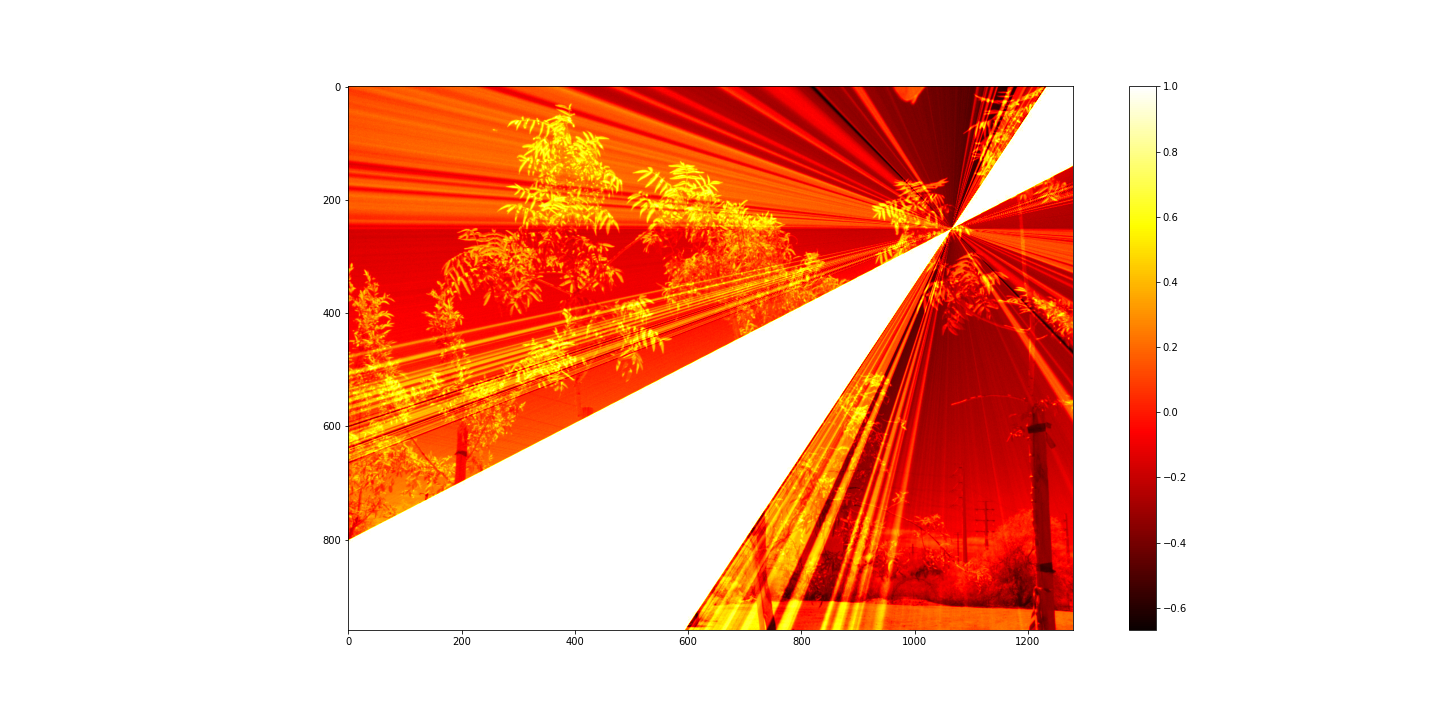

In [ ]:
def create_NDVI_map(img):

  print(img)

  img1 = cv2.imread(img+'_1.tif')
  img2 = cv2.imread(img+'_2.tif')
  img3 = cv2.imread(img+'_3.tif')
  img4 = cv2.imread(img+'_4.tif')
  img5 = cv2.imread(img+'_5.tif')

  print(img3.shape)

  print("Aligning images ...")
  # Registered image will be resotred in imReg.
  # The estimated homography will be stored in h.
  imReg, h = alignImages(img3, img5)

  # Write aligned image to disk.
  outFilename = "aligned.jpg"
  print("Saving aligned image : ", outFilename);
  cv2.imwrite(outFilename, imReg)

  # Print estimated homography
  # print("Estimated homography : \n",  h)

  img_aligned = cv2.imread("aligned.jpg")
  RED = np.array(img_aligned[:,:,0], dtype = np.float64)
  NIR = np.array(img5[:,:,0], dtype = np.float64)

  NDVI = (NIR-RED)/(NIR+RED)

  plt.figure(figsize=(20,10))
  plt.imshow(NDVI, cmap='hot')
  plt.colorbar()
  # plt.savefig(img+'_NDVI.png')
  plt.savefig('_NDVI.png')
  plt.close() 

  # Un aligned
  # RED = np.array(img3[:,:,0], dtype = np.float64)
  # NIR = np.array(img5[:,:,0], dtype = np.float64)

  # NDVI = (NIR-RED)/(NIR+RED)
  # plt.figure(figsize=(20,10))
  # plt.imshow(NDVI, cmap='hot')
  # plt.colorbar()
  # # plt.savefig(img+'_NDVI.png')
  # plt.savefig('_NDVI_ua.png')
  # plt.close() 

  # Creating RGB image 
  im_b, h = alignImages(img1, img2)
  outFilename = "aligned_blue.jpg"
  cv2.imwrite(outFilename, im_b)

  im_blue = cv2.imread("aligned_blue.jpg")
  im_r, h = alignImages(img3, img2)
  outFilename = "aligned_red.jpg"
  cv2.imwrite(outFilename, im_r)

  t = (im_r[:,:,0].reshape(960, 1280, 1), img2[:,:,0].reshape(960, 1280, 1), im_b[:,:,0].reshape(960, 1280, 1))
  rgb_img = np.concatenate(t, axis=-1)
  rgb_img = np.array(rgb_img)
  

  # Un aligned
  # t = (img3[:,:,0].reshape(960, 1280, 1), img2[:,:,0].reshape(960, 1280, 1), img1[:,:,0].reshape(960, 1280, 1))
  # rgb_img_ua = np.concatenate(t, axis=-1)
  # rgb_img_ua = np.array(rgb_img_ua)

  # plt.imsave(img+"_rgb.png", rgb_img)
  plt.imsave("_rgb.png", rgb_img)
  # plt.imsave("_rgb_ua.png", rgb_img)

/content/drive/MyDrive/DREAMS-LAB/Multispectral/Week2/Week2_Apr28_11AM/IMG_0005
(960, 1280, 3)
Aligning images ...
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Saving aligned image :  aligned.jpg
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


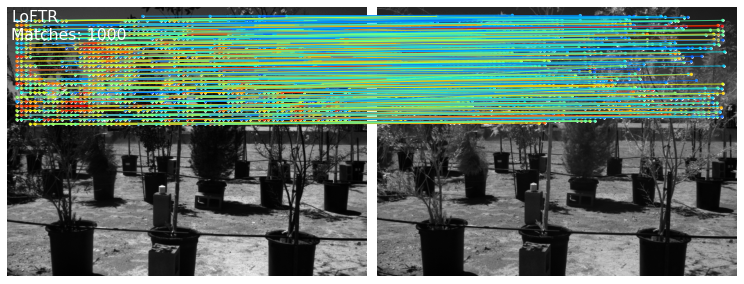

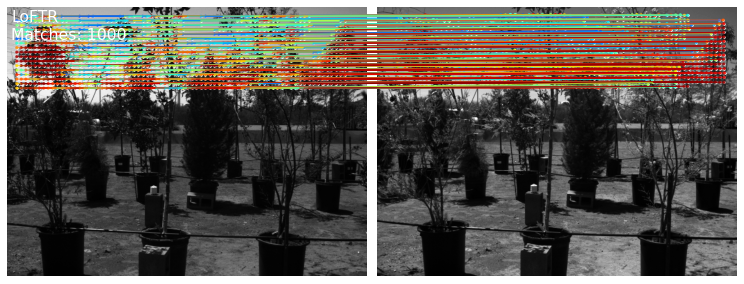

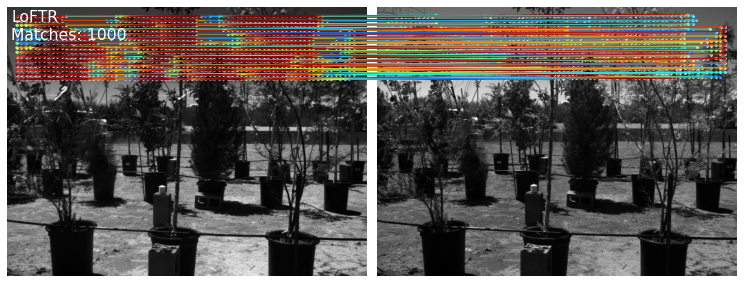

In [ ]:
create_NDVI_map('/content/drive/MyDrive/DREAMS-LAB/Multispectral/Week2/Week2_Apr28_11AM/IMG_0005')